In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import sys
from IPython import display


#-- this selects the first GPU
os.environ['CUDA_VISIBLE_DEVICES']="0"

from os import listdir

from pickle import dump
from pickle import load

import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from tensorflow.python.client import device_lib

from pickle import dump


#has_gpu = False

has_gpu = True



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    #os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


    print("\n\n printing physical devbices from tf.config.list_physical_devices\n\n")
    print(physical_devices)

    devices = device_lib.list_local_devices()

    print("\n\n printing devices from device_lib.list_local_devices\n\n")
    print(devices)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing physical devbices from tf.config.list_physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing devices from device_lib.list_local_devices


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1787368600873937978
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22949199872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4238949480468488806
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-08-11 17:30:42.490821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:42.509974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:42.510214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:42.513116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:42.513306: I tensorflow/compiler/xla/stream_executo

In [3]:


training_name = 'training-bce-mse-version1a'

testmode = False
testmode = True

run_training = True
#run_training = False


#use_weights = True
use_weights = False

if run_training :
    
    try:
        os.mkdir( '%s-training-output' % training_name )
    except:
        print('\n  Dir %s-training-output already exists\n\n' % training_name )
        print('\n\n HALTING EXECUTION \n\n')
        sys.exit()

        

#--- Hyperparameter settings.


    
#-- settings for nominal running
#max_events =   120000
#max_events =   300000
#max_events =   600000
max_events =  1000000
#max_events =  3000000

#max_events = 15000000
#max_events = 1e9


learning_rate_setval = 5e-5
batch_size_setval = 512
max_epochs = 5000
amsgrad_setval = False
patience_setval = 40
hp_lambda = 1.0

if testmode :

#-- settings for quick syntax checking runthrough
    max_events =   600000
    learning_rate_setval = 1e-3
    batch_size_setval = 4096
    max_epochs = 200





#input_file_rapgap = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-django.root'

#input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-django.root'

input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root'
input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root'


output_dir = '%s-training-output' % training_name

parfile_name = '%s/setup.txt' % output_dir

if run_training :

    parfile = open( parfile_name,'w')

    parfile.write('%s\n' % datetime.now() )
    parfile.write('training_name : %s\n' % training_name )
    parfile.write('hp_lambda : %s\n' % hp_lambda )
    parfile.write('input_file_rapgap : %s\n' % input_file_rapgap )
    parfile.write('input_file_django : %s\n' % input_file_django )
    parfile.write('max_events : %d\n' % max_events )
    parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval )
    parfile.write('batch_size_setval : %d\n' % batch_size_setval )
    parfile.write('max_epochs : %d\n' % max_epochs )
    parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
    parfile.write('patience_setval : %g\n' % patience_setval )
    parfile.write('use_weights : %d\n' % use_weights )

    parfile.close()

print('\n\n--- Training parameters file: %s\n' % parfile_name )
print( subprocess.getoutput('cat %s' % parfile_name ) )
print('\n\n')



--- Training parameters file: training-bce-mse-version1a-training-output/setup.txt

2023-08-11 17:30:42.944949
training_name : training-bce-mse-version1a
hp_lambda : 1.0
input_file_rapgap : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root
input_file_django : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root
max_events : 600000
learning_rate_setval_reg : 0.001
batch_size_setval : 4096
max_epochs : 200
amsgrad_setval : 0
patience_setval : 40
use_weights : 0





In [4]:
%%time


ur_file_rapgap = uproot3.open(input_file_rapgap)

print (ur_file_rapgap.keys()) 
ur_tree_rapgap = ur_file_rapgap['Rapgap/minitree']
print(ur_tree_rapgap)
ur_tree_rapgap.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_rapgap   =  ur_tree_rapgap.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_rapgap.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f617a2891e0>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [5]:
%%time


ur_file_django = uproot3.open(input_file_django)

print (ur_file_django.keys()) 
ur_tree_django = ur_file_django['Django/minitree']
print(ur_tree_django)
ur_tree_django.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_django   =  ur_tree_django.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_django.shape[0] )

[b'Django;1']
<TTree b'minitree' at 0x7f617a229a20>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [6]:
pandas_df_rapgap.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_rapgap.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_rapgap.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_rapgap.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_rapgap.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_rapgap.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_rapgap.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_rapgap.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_rapgap.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [7]:
pandas_df_django.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_django.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_django.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_django.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_django.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_django.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_django.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_django.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_django.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_django.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_django.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_django.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_django.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_django.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_django.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [8]:


pandas_df_rapgap.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_rapgap.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:


pandas_df_django.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_django.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [10]:
pandas_df_rapgap.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

In [11]:
pandas_df_django.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

## Apply any event selection here.

In [12]:
pandas_df_rapgap = pandas_df_rapgap.query('Empz > 0')

pandas_df_rapgap = pandas_df_rapgap.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_rapgap = pandas_df_rapgap.query('obs_hfs_pt > 0')

pandas_df_rapgap = pandas_df_rapgap.query('from_tlv_gen_Q2 > 200')

pandas_df_rapgap = pandas_df_rapgap.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_rapgap = pandas_df_rapgap.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_rapgap:  %d ' % pandas_df_rapgap.shape[0] )



 Number of entries in pandas_df_rapgap:  123966 


In [13]:
pandas_df_django = pandas_df_django.query('Empz > 0')

pandas_df_django = pandas_df_django.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_django = pandas_df_django.query('obs_hfs_pt > 0')

pandas_df_django = pandas_df_django.query('from_tlv_gen_Q2 > 200')

pandas_df_django = pandas_df_django.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_django = pandas_df_django.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_django:  %d ' % pandas_df_django.shape[0] )



 Number of entries in pandas_df_django:  113333 


In [14]:
pandas_df_rapgap

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689,3.202085
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116,3.166307
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415,3.160574
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842,3.144557
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048,3.155321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599961,0,1,24.405752,1,0.283461,0.221700,0.071227,0.016129,0.013962,0.019490,...,37.712376,-4.033729,-1.460758,6.033998,2.058355,2.947433,False,-0.042688,0.033816,3.145838
599962,0,0,26.470289,1,-0.394084,0.544118,-0.737230,0.027526,0.027821,0.021021,...,41.649895,-3.487934,-0.750738,7.289812,1.331015,2.506685,True,0.185912,-0.067062,3.165860
599964,0,0,19.932323,1,0.487170,0.373155,-2.720732,0.006788,0.002701,0.008654,...,36.933609,-4.917424,-1.075085,5.535975,1.002115,1.711251,True,0.037301,0.053768,3.172590


In [15]:
pandas_df_django

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
20,0,0,17.255196,1,-1.066193,0.240274,1.518299,0.004745,0.002059,0.005654,...,37.362167,-5.230584,-0.867193,5.430706,0.931784,2.221198,True,0.123451,0.042788,3.177054
22,0,0,29.893789,1,0.895007,0.601942,2.087080,0.052515,0.058272,0.067616,...,38.152119,-2.721840,-2.399088,6.407556,0.984936,2.996598,True,-0.094159,0.022550,3.175841
27,0,0,23.783131,1,-0.131410,0.446848,-1.933851,0.011714,0.016146,0.008042,...,41.864983,-4.471905,-1.468582,5.587996,1.080399,2.321987,True,0.317030,-0.072573,3.076885
33,1,0,24.646885,1,1.005825,0.120665,0.242550,0.015225,0.018389,0.011058,...,41.343658,-4.208622,-1.516757,5.799310,1.080347,1.063548,False,0.240941,-0.059217,3.212621
38,0,0,12.380091,1,-2.888133,1.764309,-0.540577,0.003480,0.003441,0.003494,...,38.996613,-5.732018,-0.448362,5.348104,0.986371,3.510371,True,-0.131654,0.000914,3.076051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599975,0,0,17.030645,1,-2.039463,0.962931,0.955288,0.005116,0.006974,0.004406,...,40.486641,-5.242100,-0.795208,5.491176,1.023899,4.361492,True,-0.389356,-0.037260,3.088061
599977,0,0,21.301506,1,-0.392703,0.557192,-2.509399,0.014702,0.014472,0.015101,...,38.774117,-4.136191,-0.851233,6.541059,0.955187,2.632432,True,0.079795,0.006615,3.131365
599982,0,0,18.964705,1,0.681341,0.761786,-0.533696,0.004506,-0.014924,0.009940,...,32.817074,-4.494414,-1.609468,5.424601,0.779859,3.634881,True,0.224206,0.159233,3.131109


## Set up machine learning stuff

In [16]:
X_gen_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
]

X_obs_r = np.c_[
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]

X_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]


w_r = np.c_[
    pandas_df_rapgap['wgt'].to_numpy(),
]

Y_r = np.c_[
    np.ones(len(pandas_df_rapgap))
]

In [17]:
print(" shapes:  X_gen_r = %s , X_obs_r = %s , X_r = %s,   w_r = %s , Y_r = %s" % ( str(np.shape(X_gen_r)), str(np.shape(X_obs_r)), str(np.shape(X_r)),str(np.shape(w_r)), str(np.shape(Y_r)) ) )


 shapes:  X_gen_r = (123966, 9) , X_obs_r = (123966, 9) , X_r = (123966, 18),   w_r = (123966, 1) , Y_r = (123966, 1)


In [18]:
X_gen_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
]

X_obs_d = np.c_[
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]

X_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]


w_d = np.c_[
    pandas_df_django['wgt'].to_numpy(),
]

Y_d = np.c_[
    np.zeros(len(pandas_df_django))
]


In [19]:
print(" shapes:  X_gen_d = %s , X_obs_d = %s , X_d = %s,  w_d = %s , Y_d = %s" % ( str(np.shape(X_gen_d)), str(np.shape(X_obs_d)), str(np.shape(X_d)), str(np.shape(w_d)), str(np.shape(Y_d)) ) )

 shapes:  X_gen_d = (113333, 9) , X_obs_d = (113333, 9) , X_d = (113333, 18),  w_d = (113333, 1) , Y_d = (113333, 1)


In [20]:
X_gen = np.concatenate( [X_gen_r, X_gen_d] )
X_obs = np.concatenate( [X_obs_r, X_obs_d] )

X = np.concatenate( [X_r, X_d] )

w = np.concatenate( [w_r, w_d])

Y = np.concatenate( [Y_r, Y_d])

In [21]:
print(" shapes:  X_gen = %s , X_obs = %s ,  X = %s,  w = %s , Y = %s" % ( str(np.shape(X_gen)),  str(np.shape(X_obs)),   str(np.shape(X)),  str(np.shape(w)), str(np.shape(Y)) ) )

 shapes:  X_gen = (237299, 9) , X_obs = (237299, 9) ,  X = (237299, 18),  w = (237299, 1) , Y = (237299, 1)


In [22]:

scaler_file = "%s/input-scaler.pkl" % output_dir

if run_training :
    print("Creating new scaler.")
    scalerX = StandardScaler()
    scalerX.fit(X)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX = load( open(scaler_file, 'rb') )
    
Xs = scalerX.transform(X)


if run_training :
    print("Saving scaler to %s" % scaler_file)
    dump( scalerX, open(scaler_file, 'wb'))


Creating new scaler.
Saving scaler to training-bce-mse-version1a-training-output/input-scaler.pkl


In [23]:
X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split( Xs, Y, w, test_size=0.5 )

In [24]:
print("\n shapes:  X_gen_train = %s , X_obs_train = %s" % ( str(np.shape(X_train)), str(np.shape(X_train))))


 shapes:  X_gen_train = (118649, 18) , X_obs_train = (118649, 18)


In [25]:
Xs_d = scalerX.transform( X_d )

Xs_r = scalerX.transform( X_r )


In [26]:
X_train

array([[ 0.56844172, -0.26811412,  0.79648247, ...,  0.88926699,
        -0.56266625, -0.0960609 ],
       [ 0.05775059, -0.2237631 ,  0.17375927, ...,  0.0721977 ,
        -1.5512601 ,  1.22477481],
       [ 0.18518699, -0.05450055,  0.46376918, ...,  0.3027664 ,
        -0.60001223, -0.28504255],
       ...,
       [-1.31629386,  0.59847236, -0.96394693, ..., -0.68409087,
         0.16966814, -1.35265541],
       [-0.09858715, -0.56211705, -0.43120324, ..., -0.12309497,
        -0.36555364,  0.12308204],
       [-0.82057262,  0.22780617, -0.61391328, ..., -0.37442127,
         0.84202292, -4.3240533 ]])

In [27]:
Y_train

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [28]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def custom_loss_simple(y_true, y_pred):
    particle_level = y_pred
    loss = bce(y_true,particle_level)  
    return loss

## Pre-train a simple particle-level classifier

In [29]:
n = 9  # Number of features in input.

inputs = Input(shape=(2*n,))


classifier_nn = Sequential()
classifier_nn.add( Dense( 50, activation="relu", input_dim=n) )
classifier_nn.add( Dense( 50, activation="relu"))
classifier_nn.add( Dense( 1, activation="sigmoid"))

particle_inputs_model = classifier_nn( inputs[:,0:n] )

output = particle_inputs_model


mymodel = Model( inputs=[inputs], outputs=[output])

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

#mymodel.compile( loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'] )

mymodel.compile( loss=custom_loss_simple, optimizer=opt_adam, metrics=['accuracy'] )


2023-08-11 17:30:45.437333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:45.437579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:45.437750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:45.437959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 17:30:45.438127: I tensorflow/compiler/xla/stream_executo

In [30]:
training_hist = mymodel.fit( X_train, Y_train, validation_data=(X_test, Y_test), 
            epochs=50, 
            batch_size=batch_size_setval,
           verbose=1)

Epoch 1/50


/usr/lib/python3/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-11 17:30:46.672228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-11 17:30:46.674695: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5a8801d010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-11 17:30:46.674714: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-08-11 17:30:46.681357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-11

29/29 [==============================] - 2s 9ms/step - loss: 0.6867 - accuracy: 0.5510 - val_loss: 0.6750 - val_accuracy: 0.5862
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5939 - val_loss: 0.6675 - val_accuracy: 0.6026
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6076 - val_loss: 0.6636 - val_accuracy: 0.6101
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6135 - val_loss: 0.6617 - val_accuracy: 0.6144
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6590 - accuracy: 0.6156 - val_loss: 0.6602 - val_accuracy: 0.6144
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6172 - val_loss: 0.6591 - val_accuracy: 0.6157
Epoch 7/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6181 - val_loss: 0.6578 - val_accuracy: 0.6173
Epoch 8/50
29/29 [=============

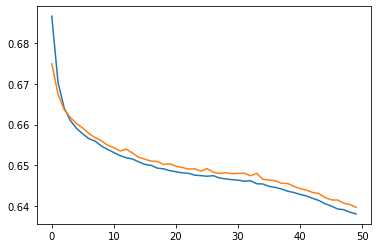

In [31]:
plt.plot( training_hist.history['loss'] )
plt.plot( training_hist.history['val_loss'] )

In [32]:
mymodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 tf.__operators__.getitem (S  (None, 9)                0         
 licingOpLambda)                                                 
                                                                 
 sequential (Sequential)     (None, 1)                 3101      
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [33]:
preds = mymodel.predict( X_test, batch_size=1024 )

116/116 [==============================] - 0s 542us/step


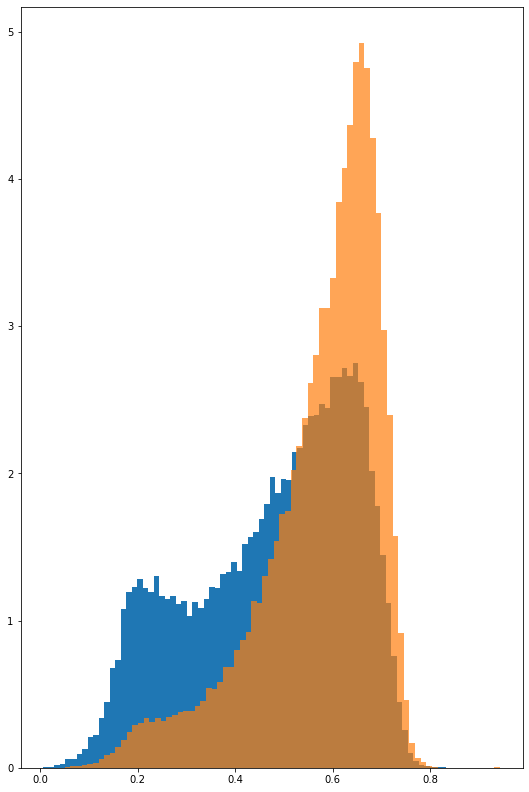

In [34]:
fig,ax = plt.subplots(1,1,figsize=(9,14))

ax.hist( preds[Y_test==0], density=True, bins=80)
ax.hist( preds[Y_test==1], density=True, bins=80, alpha=0.7)


plt.show()

## Set up model

In [35]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def custom_loss(y_true, y_pred):
    particle_level = y_pred[:,0]
    detector_level = y_pred[:,1]
    loss = bce(y_true,particle_level)  + tf.reduce_mean(tf.square(particle_level - detector_level)) 
    return loss

In [36]:
n = 9  # Number of features in input.

#inputs = Input(shape=(2*n,))

#classifier_nn = Sequential()
#classifier_nn.add( Dense( 50, activation="relu", input_dim=n) )
#classifier_nn.add( Dense( 50, activation="relu"))
#classifier_nn.add( Dense( 1, activation="sigmoid"))

particle_inputs_model2 = classifier_nn( inputs[:,0:n] )
detector_inputs_model2 = classifier_nn( inputs[:,n:] )

output2 = tf.stack( [particle_inputs_model2, detector_inputs_model2], axis=1)


mymodel2 = Model( inputs=[inputs], outputs=[output2])

#opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

mymodel2.compile( loss=custom_loss, optimizer=opt_adam, metrics=['accuracy'] )


In [37]:
training_hist2 = mymodel2.fit( X_train, Y_train, validation_data=(X_test, Y_test), 
            epochs=150, 
            batch_size=batch_size_setval,
           verbose=1)

Epoch 1/150
29/29 [==============================] - 1s 8ms/step - loss: 0.7001 - accuracy: 0.5012 - val_loss: 0.6896 - val_accuracy: 0.4774
Epoch 2/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.4778 - val_loss: 0.6883 - val_accuracy: 0.4774
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.4778 - val_loss: 0.6880 - val_accuracy: 0.4774
Epoch 4/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.4778 - val_loss: 0.6879 - val_accuracy: 0.4774
Epoch 5/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.4778 - val_loss: 0.6877 - val_accuracy: 0.4774
Epoch 6/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.4779 - val_loss: 0.6876 - val_accuracy: 0.4774
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.4779 - val_loss: 0.6875 - val_accuracy: 0.4774
Epoch 8/150
2

Epoch 59/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4778 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 60/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4778 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 61/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4778 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 62/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4778 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 63/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4779 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 64/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4778 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 65/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.4779 - val_loss: 0.6864 - val_accuracy: 0.4774
Epoch 

29/29 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.4778 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 117/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4779 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 118/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.4778 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 119/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.4779 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 120/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4779 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 121/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4779 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 122/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4779 - val_loss: 0.6860 - val_accuracy: 0.4774
Epoch 123/150

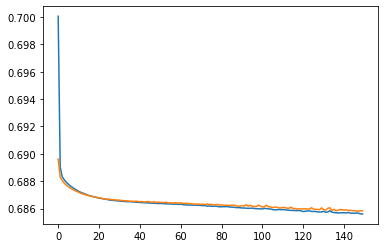

In [38]:
plt.plot( training_hist2.history['loss'] )
plt.plot( training_hist2.history['val_loss'] )

In [39]:
mymodel2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 9)           0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 9)           0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                            

In [40]:
preds2 = mymodel2.predict( X_test, batch_size=1024 )

116/116 [==============================] - 0s 616us/step


In [41]:
preds2

array([[[0.12318175],
        [0.10358152]],

       [[0.23463619],
        [0.1940717 ]],

       [[0.0139941 ],
        [0.00675069]],

       ...,

       [[0.09462325],
        [0.00897379]],

       [[0.2741593 ],
        [0.23523584]],

       [[0.20746726],
        [0.22791107]]], dtype=float32)

In [42]:
np.shape(preds2)

(118650, 2, 1)

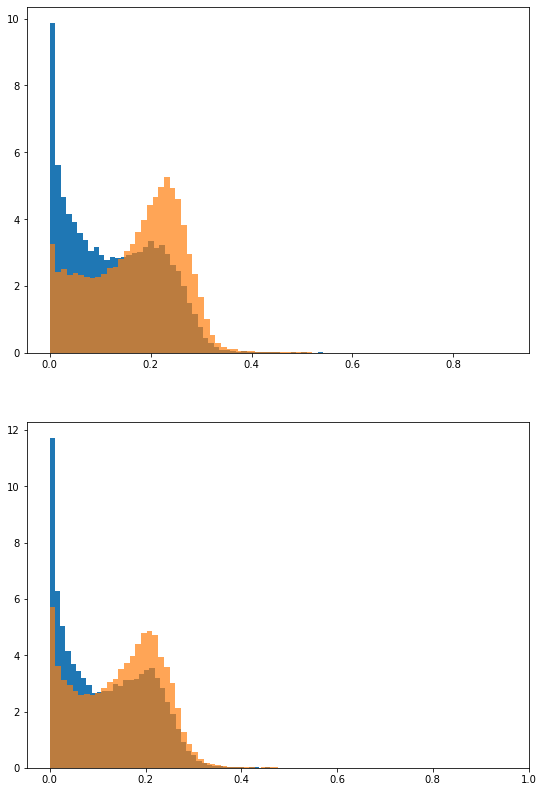

In [43]:
fig,ax = plt.subplots(2,1,figsize=(9,14))

ax[0].hist( preds2[:,0][Y_test==0], density=True, bins=80)
ax[0].hist( preds2[:,0][Y_test==1], density=True, bins=80, alpha=0.7)


ax[1].hist( preds2[:,1][Y_test==0], density=True, bins=80)
ax[1].hist( preds2[:,1][Y_test==1], density=True, bins=80, alpha=0.7)

plt.show()


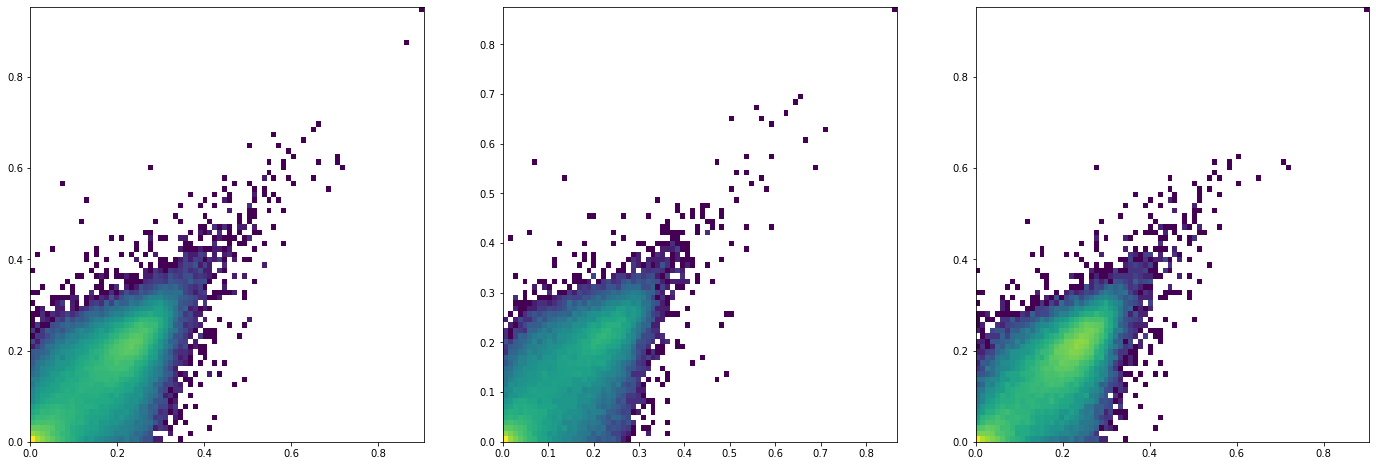

In [44]:
fig,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( preds2[:,0][Y_test>-1], preds2[:,1][Y_test>-1], bins=80, norm=mpl.colors.LogNorm())
ax[1].hist2d( preds2[:,0][Y_test==0], preds2[:,1][Y_test==0], bins=80, norm=mpl.colors.LogNorm())
ax[2].hist2d( preds2[:,0][Y_test==1], preds2[:,1][Y_test==1], bins=80, norm=mpl.colors.LogNorm())

plt.show()